### Add Fumehood Data
This notebook queries raw data from WebCTRL, calculates fumehood energy and sash position data, and adds this data into Steve's SQL database.

In [1]:
from query.query_biotech import fume_query, query_to_list
import random
import time
import requests
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil import tz
import matplotlib.pyplot as plt

### Metrics Functions
These functions calculate the metrics we want (time sash open and energy usage) from the raw WebCTRL data

In [55]:
def total_time_sash_open(sash_point, server, start, end):
  df = pd.DataFrame(query_to_list(sash_point, server, start, end))
  
  df.columns = ["sash"]
  # display(df)

  time_interval = df.index[1].minute - df.index[0].minute
  # print("Time interval", time_interval)

  display(df)
  # from running the above on a large time difference, 1.2 inches is the most common smallest value
  df["time_open_mins"] = np.where((df["sash"] > 1.2), time_interval, 0)
  display(df)

  df = df.dropna()
  df.index = df.index.map(lambda x: x.to_pydatetime().replace(tzinfo=tz.tzutc()).astimezone(tz.tzlocal()))
  display(df)

  df = df.groupby(pd.Grouper(freq='15Min', label='right')).sum()
  df.index = df.index.map(lambda x: x.to_pydatetime().timestamp())
  display(df)

  return df["time_open_mins"]

In [9]:
# def sash_position_trend(sash_point, occ_point, server, start, end):
#   sash_list = query_to_list(sash_point, server, start, end)
#   occ_list = query_to_list(occ_point, server, start, end)

#   df = pd.concat([sash_list, occ_list], axis=1)
#   df.columns = ["sash", "occ"]
#   # display(df)

#   df = df.dropna()
#   df.index = df.index.map(lambda x: x.to_pydatetime().replace(tzinfo=tz.tzutc()).astimezone(tz.tzlocal()))
#   # display(df)

#   # df.to_csv("test.csv")

#   # df = df.groupby(pd.Grouper(freq='15Min', label='right')).first()
#   df['minute'] = df.index.map(lambda x: x.to_pydatetime().minute)
#   df = df[df['minute'].isin([0, 15, 30, 45])]
#   display(df)

#   df.index = df.index.map(lambda x: x.to_pydatetime().timestamp())
#   # display(df)

#   unocc_df = df[df['occ']==0]
#   occ_df = df[df['occ']==1]

#   return (unocc_df["sash"], occ_df["sash"])

In [10]:
# Arguments: CFM Point, Sash Point, Occ Point, Internal Temp Point, External Temp Point, Server Name, Start Time, End Time
# Returns: Total energy from hume hood, aggregated by hour.

# A switch in the energy calculations that allows us to avoid issues between times of years where it is hotter/colder outside.
def coldorhot(cfm, external, internal, time_interval):
    if external<=internal:
        #sensible heating equation
        return round(1.08 * cfm * (internal - external) / (60 / time_interval), 3)
    if external>internal:
        #enthalpy of air
        return round(0.24 * cfm /13.333 * 60 * (external - internal) / (60 / time_interval), 3)

def total_energy(cfm_point, sash_point, occ_point, internal_temp_point, external_temp_point, server, start, end):
  #external_temp_master = outside_temp(start,end)
  cfm_list = query_to_list(cfm_point, server, start, end)
  sash_list = query_to_list(sash_point, server, start, end)
  occ_list = query_to_list(occ_point, server, start, end)
  internal_temp_list = query_to_list(internal_temp_point, server, start, end)
  external_temp_list = query_to_list(external_temp_point, server, start, end)

  df = pd.concat([cfm_list, sash_list, occ_list, internal_temp_list, external_temp_list], axis=1)
  df.columns = ["cfm", "sash", "occ", "internal_temp", "external_temp"]
  display(df)

  df['minute'] = df.index.map(lambda x: x.to_pydatetime().minute)
  df = df[df['minute'].isin([0, 15, 30, 45])]
  display(df)

  df["external_temp"] = df["external_temp"].interpolate()
  display(df)
  
  time_interval = df.index[1].minute - df.index[0].minute

  df['BTU'] = df.apply(lambda df: coldorhot(df['cfm'], df['external_temp'], df['internal_temp'], time_interval=time_interval), axis=1)
  
  df.index = df.index.map(lambda x: x.to_pydatetime().replace(tzinfo=tz.tzutc()).astimezone(tz.tzlocal()))
  display(df)

  # df = df.groupby(pd.Grouper(freq='60Min', label='right')).sum()
#  df.index = df.index.strftime('%s').astype("int")
  df.index = df.index.map(lambda x: x.to_pydatetime().timestamp())
  display(df)

  unocc_df = df[df['occ']==0]
  occ_df = df[df['occ']==1]

  return (unocc_df["sash"], occ_df["sash"], unocc_df["BTU"], occ_df["BTU"])

### Insert into Database Function
This function takes in the name of a "pseudo point" and inserts the relevant data into Steve's SQL database.

In [58]:
# the x-api-key is the secret authentication to allow posting updates
headers = {"x-api-key": "LfSpEZ3woOuljzb2EAg0"}
# the endpoint URL for trend updates
TREND_API_URL = "https://7zhs2wplt9.execute-api.us-east-1.amazonaws.com/dev/trend"
# time in seconds that the request will timeout if no response is received.
# the API will only run for 6 seconds, so if it can't process
# the data posted in that amount of time it will fail.
API_TIMEOUT = 30

# timestamps
now = int(time.time())
last_hour = now - now % 3600
start_time = last_hour - (3600 * 6)

def insert_into_database(pseudo_point, data):
    # data = [compute_value(point, ts) for ts in range(start_time, last_hour, 3600)]
    data = np.fliplr(data.reset_index().to_numpy()).tolist()
    print(data)

    json_obj = {"object_name": pseudo_point, "data": data }
    # e.g.
    # { "object_name": "Biotech.GroundFloor.Lab_g54.Hood_1.energy.occ",
    # "data": [[0, 1681462800], [0, 1681466400], [0, 1681470000], [4.430475, 1681473600]],
    # }
    req_start = time.time()
    response = requests.post(TREND_API_URL, json=json_obj, headers=headers, timeout=API_TIMEOUT)
    req_end = time.time()
    r = response.json()
    print(f"""received status_code:{response.status_code} msg:{r.get('message', None)}
    rows:{r.get('affectedRows', None)} duplicates:{r.get('duplicates', None)} 
    for point:{pseudo_point} with id:{r.get('obj_id', None)} in {req_end-req_start:.3f} seconds.""")

### Insert into Database
This cell actually runs the code to insert the data processed above into Steve's SQL database

TODO
1. Load the namingconvention.csv to obtain the structure of biotech along with all points
2. For each row (fume hood) of the csv, pass the point names into the queries.  For example, pass the point names for the current hood to calculate a total_time_sash_open for that hood (do this for occ and unocc).  Do this for both the sash open and energy metrics.
3. After doing this, also for each row, insert the data into Steve's database using the correct pseudo-point name (the last four rows of the csv)

- Start this at the beginning of 2023


In [61]:
print("DOWNLOADING DATA")
# trend_data = total_energy(cfm_point="#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_441_control/hoodvalve_flow/trend_log",
#                                  sash_point="#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_441_control/hood_sash",
#                                  occ_point="#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_441_control/occ",
#                                  internal_temp_point="#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_441_control/zone/zone_temp/trend_log",
#                                  external_temp_point="#biotech/ground_flr_mech/building_hydronic_heating_syatems/reheat_heat_exchanger/oat",
#                                  server="biotech_main",
#                                  start=str(datetime(2024, 3, 15)),
#                                  end=str(datetime.now()))

sashOpenData = total_time_sash_open(sash_point="#biotech/biotech_4th_floor/fourth_floor_fume_hood_lab_spaces/lab_441_control/hood_sash",
                                    server="biotech_main", start=str(datetime(2024, 3, 15)),
                                 end=str(datetime.now()))


print("INSERTING SASH TIME INTO DATABASE")
insert_into_database("Biotech.Floor_4.Lab_441.Hood_1.sashOpenTime.unocc", sashOpenData)
# insert_into_database("Biotech.Floor_4.Lab_441.Hood_1.sashOpenTime.unocc", trend_data[0])

print("INSERTING SASH OCC INTO DATABASE")
insert_into_database("Biotech.Floor_4.Lab_441.Hood_1.sashOpenTime.occ", trend_data[1])

print("INSERTING ENERGY UNOCC INTO DATABASE")
insert_into_database("Biotech.Floor_4.Lab_441.Hood_1.energy.unocc", trend_data[2])

print("INSERTING ENERGY OCC INTO DATABASE")
insert_into_database("Biotech.Floor_4.Lab_441.Hood_1.energy.occ", trend_data[3])

# a list of points
points = [
    # "Biotech.Floor_4.Lab_433.Hood_1.energy.occ",
    # "Biotech.Floor_4.Lab_433.Hood_1.energy.unocc",
    # "Biotech.Floor_4.Lab_433.Hood_1.sashOpenTime.occ",
    # "Biotech.Floor_4.Lab_433.Hood_1.sashOpenTime.unocc",
    # "Biotech.GroundFloor.Lab_g54.Hood_1.energy.unocc",
    # "Biotech.GroundFloor.Lab_g54.Hood_1.sashOpenTime.occ",
]

DOWNLOADING DATA
<Response [200]>


,sash
2024-03-15 04:00:00,3.2
2024-03-15 04:15:00,3.2
2024-03-15 04:30:00,3.2
2024-03-15 04:45:00,3.2
2024-03-15 05:00:00,3.2
...,...
2024-05-04 18:00:00,1.4
2024-05-04 18:15:00,1.4
2024-05-04 18:30:00,1.4
2024-05-04 18:45:00,1.4


,sash,time_open_mins
2024-03-15 04:00:00,3.2,15
2024-03-15 04:15:00,3.2,15
2024-03-15 04:30:00,3.2,15
2024-03-15 04:45:00,3.2,15
2024-03-15 05:00:00,3.2,15
...,...,...
2024-05-04 18:00:00,1.4,15
2024-05-04 18:15:00,1.4,15
2024-05-04 18:30:00,1.4,15
2024-05-04 18:45:00,1.4,15


,sash,time_open_mins
2024-03-15 00:00:00-04:00,3.2,15
2024-03-15 00:15:00-04:00,3.2,15
2024-03-15 00:30:00-04:00,3.2,15
2024-03-15 00:45:00-04:00,3.2,15
2024-03-15 01:00:00-04:00,3.2,15
...,...,...
2024-05-04 14:00:00-04:00,1.4,15
2024-05-04 14:15:00-04:00,1.4,15
2024-05-04 14:30:00-04:00,1.4,15
2024-05-04 14:45:00-04:00,1.4,15


,sash,time_open_mins
1.710476e+09,3.2,15
1.710477e+09,3.2,15
1.710478e+09,3.2,15
1.710479e+09,3.2,15
1.710480e+09,3.2,15
...,...,...
1.714846e+09,1.4,15
1.714847e+09,1.4,15
1.714848e+09,1.4,15
1.714849e+09,1.4,15


INSERTING SASH TIME INTO DATABASE
[[15.0, 1710476100.0], [15.0, 1710477000.0], [15.0, 1710477900.0], [15.0, 1710478800.0], [15.0, 1710479700.0], [15.0, 1710480600.0], [15.0, 1710481500.0], [15.0, 1710482400.0], [15.0, 1710483300.0], [15.0, 1710484200.0], [15.0, 1710485100.0], [15.0, 1710486000.0], [15.0, 1710486900.0], [15.0, 1710487800.0], [15.0, 1710488700.0], [15.0, 1710489600.0], [15.0, 1710490500.0], [15.0, 1710491400.0], [15.0, 1710492300.0], [15.0, 1710493200.0], [15.0, 1710494100.0], [15.0, 1710495000.0], [15.0, 1710495900.0], [15.0, 1710496800.0], [15.0, 1710497700.0], [15.0, 1710498600.0], [15.0, 1710499500.0], [15.0, 1710500400.0], [15.0, 1710501300.0], [15.0, 1710502200.0], [15.0, 1710503100.0], [15.0, 1710504000.0], [15.0, 1710504900.0], [15.0, 1710505800.0], [15.0, 1710506700.0], [15.0, 1710507600.0], [15.0, 1710508500.0], [15.0, 1710509400.0], [15.0, 1710510300.0], [15.0, 1710511200.0], [15.0, 1710512100.0], [15.0, 1710513000.0], [15.0, 1710513900.0], [15.0, 1710514800.0

NameError: name 'trend_data' is not defined

### Testing
These cells are used for testing purposes

<Response [200]>
<Response [200]>


,occ,unocc
2023-04-21 20:00:00-04:00,0.000000,0.000000
2023-04-22 20:00:00-04:00,0.000000,0.000000
2023-04-23 20:00:00-04:00,0.000000,0.000000
2023-04-24 20:00:00-04:00,0.000000,0.000000
2023-04-25 20:00:00-04:00,1.666667,0.000000
...,...,...
2023-11-20 19:00:00-05:00,1.682759,1.368056
2023-11-21 19:00:00-05:00,1.515464,1.387500
2023-11-22 19:00:00-05:00,0.276923,1.933333
2023-11-23 19:00:00-05:00,0.353846,1.400930


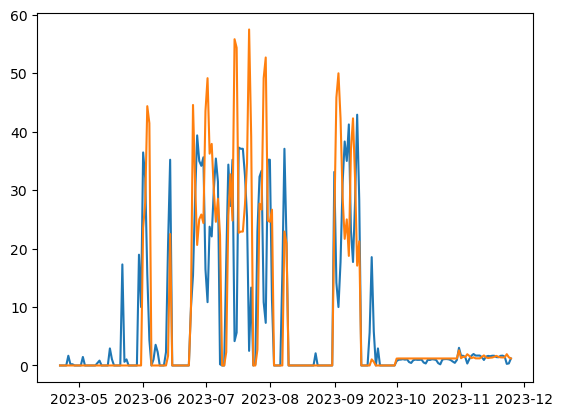

In [349]:
def synthetic_query(target, start, end):
    url = "https://portal.emcs.cornell.edu/api/datasources/proxy/5/query"
    data = {
        "range": {
            "from": start,
            "to": end,
        },
        "targets": [
            {
                "target": target
            }
        ],

    }
    request = requests.post(url, json=data)
    print(request)
    # print(request.json())
    master = create_tuple(request)
    list = pd.Series(data=[i[0] for i in master],
                     index=[i[1] for i in master])

    list = list[~list.index.duplicated()]

    return list

sash_data_occ = synthetic_query(target="Biotech.Floor_4.Lab_433.Hood_1.sashOpenTime.occ",
                                    start=str(datetime(2023, 4, 22)),
                                    end=str(datetime.now()))

sash_data_unocc = synthetic_query(target="Biotech.Floor_4.Lab_433.Hood_1.sashOpenTime.unocc",
                                      start=str(datetime(2023, 4, 22)),
                                      end=str(datetime.now()))

final_df = pd.DataFrame(
        data={"occ": sash_data_occ, "unocc": sash_data_unocc})
final_df = final_df.fillna(0)
final_df.index = final_df.index.map(lambda x: x.to_pydatetime().replace(tzinfo=tz.tzutc()).astimezone(tz.tzlocal()))
display(final_df)
plt.plot(final_df)